### Reproducing results for Global-Symmetry dataset using InceptionV4

In [ ]:
import os
import sys
import numpy as np
import pickle
import gzip
import shutil
from scipy import misc
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress tracking

import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2  # Using Inception V4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#### Utility functions

In [ ]:
tf.keras.backend.set_image_data_format('channels_last')

def read_dataset(filename='alldata.data'):
    if filename[-3:] == '.gz':
        with gzip.open(filename, 'rb') as f:
            dataxy = pickle.load(f, encoding='latin1')
    else:
        with open(filename, 'rb') as f:
            dataxy = pickle.load(f, encoding='latin1')
    return dataxy

def save_dataset(filename='alldata.data.gz', data=None):
    if filename[-3:] == '.gz':
        with gzip.open(filename, 'wb') as f:
            pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(filename, 'wb') as f:
            pickle.dump(data, f, protocol=2)

def preprocessing_img(x):
    x = np.asarray(x).astype(np.float32)
    x /= 255.0
    return x

def add_random_noise(image):
    if np.random.rand() > 0.4:
        if np.random.rand() > 0.5:
            return add_noise(image, 'gauss')
        else:
            return add_noise(image, 's&p')
    else:
        return image

def add_noise(image, noise_typ='gauss'):
    maxv = max(1, np.max(image))
    
    if noise_typ == "gauss":
        mean = 0
        var = 0.1 * maxv
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, image.shape)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        out[coords] = maxv
        
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ == "speckle":
        gauss = np.random.randn(*image.shape)
        noisy = image + image * gauss
        return noisy

#### InceptionV4

In [ ]:
def build_inceptionV4(input_shape):
    input_tensor = Input(shape=input_shape)

    base_model = InceptionResNetV2(input_tensor=input_tensor, weights='imagenet', include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=predictions)
    
    return base_model, model

## Round 1 (Model M1)

In [3]:
argv=['/global-symmetry-ds1', 'None', '0']

In [4]:
ds = argv[0]
resume_model = argv[1] if len(argv) > 1 and argv[1] != 'None' else None
im_noise = int(argv[2]) == 1 if len(argv) > 2 else False

nb_epoch2 = 10

#### Training (B1 and C1)

In [5]:
if not os.path.exists('models'):
    os.mkdir('models')

# Load data
tx, ty = read_dataset(os.path.join(ds, 'train.data'))
vx, vy = read_dataset(os.path.join(ds, 'valid.data'))

nTrainSample = len(ty)

tx = preprocessing_img(tx)
vx = preprocessing_img(vx)

tx = np.asarray(tx)[:, :, :, np.newaxis]  # Add a new axis for channels at the end
vx = np.asarray(vx)[:, :, :, np.newaxis]  # Add a new axis for channels at the end
tx = np.repeat(tx, 3, axis=-1)  # Repeat across the last axis (channels) for NHWC format
vx = np.repeat(vx, 3, axis=-1)  # Repeat across the last axis (channels) for NHWC format

ty = to_categorical(ty, 2)
vy = to_categorical(vy, 2)


In [6]:
# Build model
base_model, model = build_inceptionV4(input_shape=(200, 200, 3))

In [7]:
datagen = ImageDataGenerator(
        preprocessing_function=add_random_noise if im_noise else None,
        rotation_range=5,
        width_shift_range=0.02,
        height_shift_range=0.02,
        horizontal_flip=True,
        vertical_flip=True
    )

if resume_model is not None:
    print('Resume model: ', resume_model)
    model.load_weights(resume_model)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model_str = f"{ds}_incep4-{{epoch:02d}}-{{val_accuracy:.3f}}.weights.h5"
filepath2 = f"models/{model_str}"
checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max', save_weights_only=True)

early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=40)

callbacks_list2 = [early_stopper, checkpoint2]

In [8]:
# Train the model
steps_per_epoch = nTrainSample // 400  # Ensure integer division
model.fit(datagen.flow(tx, ty, batch_size=40, shuffle=True),
              steps_per_epoch=steps_per_epoch,
              epochs=nb_epoch2,
              validation_data=(vx, vy),
              callbacks=callbacks_list2)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729865674.677190     257 service.cc:145] XLA service 0x7a5d300065e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729865674.677255     257 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729865674.677260     257 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729865741.732272     257 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.5809 - loss: 1.6892 - val_accuracy: 0.8135 - val_loss: 0.5846
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8939 - loss: 0.3242 - val_accuracy: 0.9795 - val_loss: 0.0555
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9019 - loss: 0.2850 - val_accuracy: 0.9129 - val_loss: 0.4008
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9317 - loss: 0.1987 - val_accuracy: 0.9162 - val_loss: 0.4093
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9344 - loss: 0.1522 - val_accuracy: 0.9771 - val_loss: 0.1100
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9714 - loss: 0.0766 - val_accuracy: 0.8940 - val_loss: 0.3840
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9420 - loss: 0.1364 - val_accuracy: 0.9539 - val_loss: 0.2949
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9687 - loss: 0.1004 - val_accuracy: 0.9204 - val_loss: 0.4016
Ep

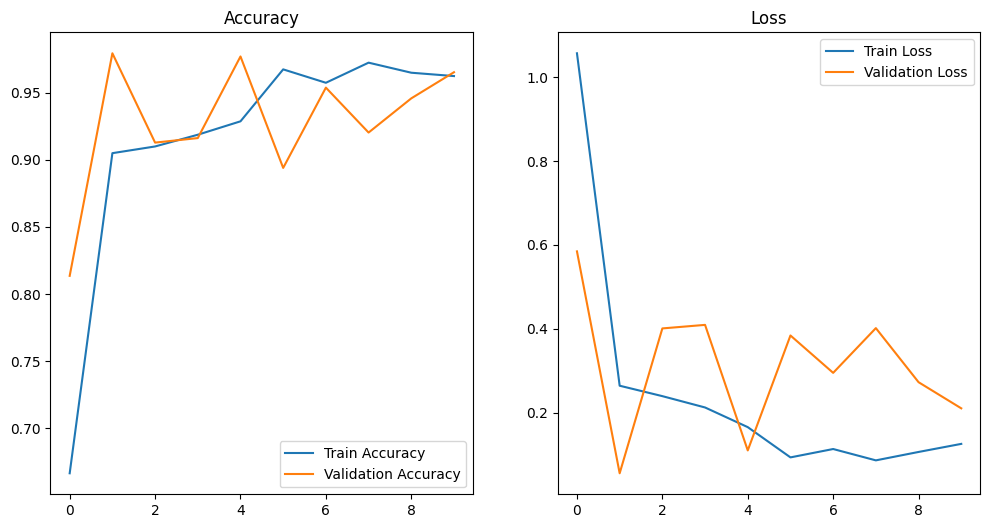

In [10]:
# Plot training progress
history = model.history.history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

We can see that the model has learned the weights pretty well, with **train_accuracy and val_accuaracy reaching around 96%.**

In [11]:
m1_weights = model.get_weights()
print("Model weights saved to a variable.")

Model weights saved to a variable.


#### Testing on A1

In [12]:
# Load testing data
tx, ty = read_dataset(os.path.join(ds, 'test.data'))
tx = preprocessing_img(tx)
tx = np.asarray(tx)[:, :, :, np.newaxis]
tx = np.repeat(tx, 3, axis=-1)

In [13]:
base_model, model_test = build_inceptionV4(input_shape=(200, 200, 3))

In [14]:
print('loading weights: ')
model_test.set_weights(m1_weights)

loading weights: 


In [15]:
# Using tqdm for progress tracking during prediction
preds = model_test.predict(tx, verbose=0)

Confusion Matrix:
[[4000    0]
 [ 260 3740]]
Accuracy: 0.9675
Precision: 1.00
Recall: 0.94


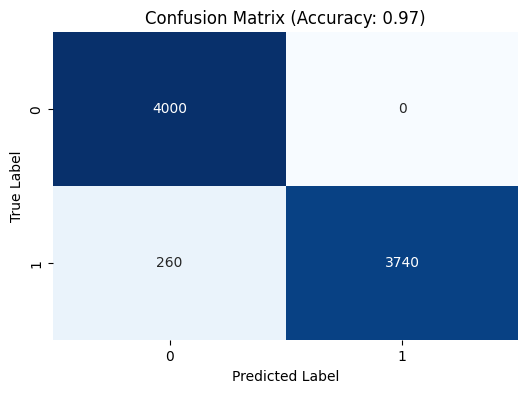

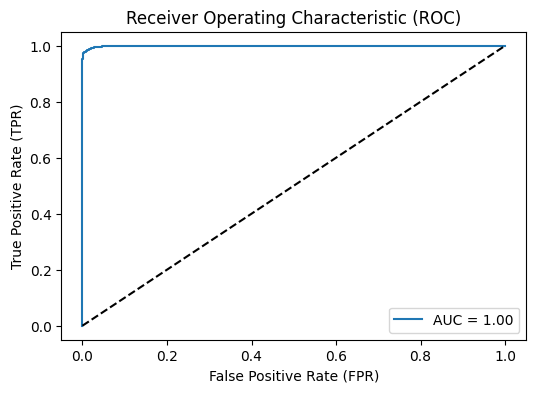

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics


# Confusion Matrix
conf_matrix = confusion_matrix(ty, preds[:, 1] > preds[:, 0])
print("Confusion Matrix:")
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(ty, preds[:, 1] > preds[:, 0])
print("Accuracy:", accuracy)

# Precision and Recall
precision = precision_score(ty, preds[:, 1] > preds[:, 0])
recall = recall_score(ty, preds[:, 1] > preds[:, 0])
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Plot confusion matrix with Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate and plot ROC curve with AUC
fpr, tpr, thresholds = metrics.roc_curve(ty, preds[:, 1], pos_label=1)
auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line for random classifier
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.show()


**Our initial test accuracy is around 96.75%.**

#### Testing on D1(A1)

In [18]:
# Load testing data
tx, ty = read_dataset(os.path.join(ds, 'train_break.data'))
tx = preprocessing_img(tx)
tx = np.asarray(tx)[:, :, :, np.newaxis]
tx = np.repeat(tx, 3, axis=-1)

In [19]:
base_model, model_test = build_inceptionV4(input_shape=(200, 200, 3))

In [20]:
print('loading weights: ')
model_test.set_weights(m1_weights)

loading weights: 


In [21]:
preds = model_test.predict(tx, verbose=0)

Confusion Matrix:
[[3990   10]
 [2805 1195]]
Accuracy: 0.648125
Precision: 0.99
Recall: 0.30


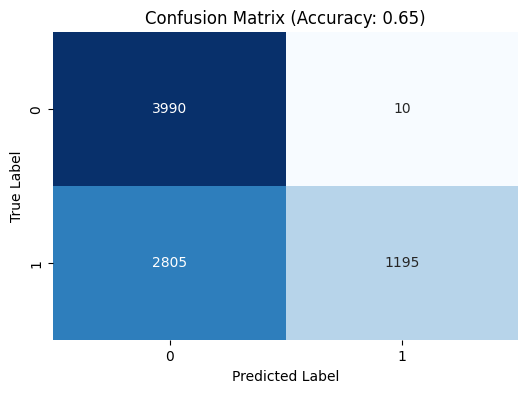

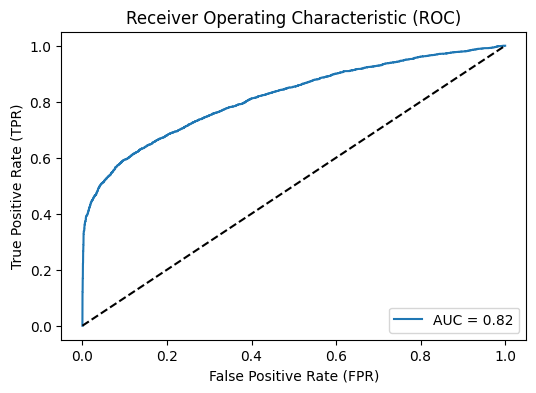

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics


# Confusion Matrix
conf_matrix = confusion_matrix(ty, preds[:, 1] > preds[:, 0])
print("Confusion Matrix:")
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(ty, preds[:, 1] > preds[:, 0])
print("Accuracy:", accuracy)

# Precision and Recall
precision = precision_score(ty, preds[:, 1] > preds[:, 0])
recall = recall_score(ty, preds[:, 1] > preds[:, 0])
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Plot confusion matrix with Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate and plot ROC curve with AUC
fpr, tpr, thresholds = metrics.roc_curve(ty, preds[:, 1], pos_label=1)
auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line for random classifier
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.show()


**Testing accuracy on the deliberate set is only 65%.**

Due to computational constraints, I was only able to reproduce the results for the first round. Here are the final results for InceptionV4:

| Test Data | Accuracy | Precision | Recall |
|----------|-----------|----------|----------|
| A1 | 0.96 | 1.00 | 0.94 |
| D1(A1) | 0.65 | 0.99 | 0.30 |